In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6864-hw2b

In [ ]:
import os
os.makedirs("6864-hw2b", exist_ok=True)
import sys
sys.path.append("/content/6864-hw2b")

In [ ]:
!pip install sacrebleu

     |████████████████████████████████| 61kB 2.2MB/s 


# **Part 3: Sequence-to-Sequence Model**



In this lab, you will explore RNN-based sequence-to-sequence (seq2seq) models to perform machine translation (MT). We will use a Vietnamese-English dataset from IWSLT'15. The task is to translate a Vietnamese sentence into English.

The lab is divided into two parts. The first part is to implement a vanilla seq2seq architecture without attention. In the second part you will implement your favorite attention mechanism (doesn't have to come from lecture) and add it to your vanilla seq2seq model. We will provide the training and testing scripts (trust me, the decoding/testing is actually the hardest part :P), so you will mainly just have to focus on implementing the models (I say *mainly* because you still might need to modify the testing script, depending on which attention method you use and how you implement it).


## **Section 1: Data Preprocessing**

No need to write any code in this section. But you are encouraged to test with this part to understand the data.

First, we download the dataset and place it under current directory.

In [ ]:
# Download data
!wget -nv -O /content/6864-hw2b/train.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget -nv -O /content/6864-hw2b/train.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget -nv -O /content/6864-hw2b/tst2013.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget -nv -O /content/6864-hw2b/tst2013.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget -nv -O /content/6864-hw2b/vocab.en https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget -nv -O /content/6864-hw2b/vocab.vi https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

2020-05-11 10:01:42 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en [13603614/13603614] -> "/content/6864-hw2b/train.en" [1]
2020-05-11 10:01:46 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi [18074646/18074646] -> "/content/6864-hw2b/train.vi" [1]
2020-05-11 10:01:47 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en [132264/132264] -> "/content/6864-hw2b/tst2013.en" [1]
2020-05-11 10:01:49 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi [183855/183855] -> "/content/6864-hw2b/tst2013.vi" [1]
2020-05-11 10:01:52 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en [139741/139741] -> "/content/6864-hw2b/vocab.en" [1]
2020-05-11 10:01:53 URL:https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi [46767/46767] -> "/content/6864-hw2b/vocab.vi" [1]


Next, we do some simple data preprocessing and show some data statistics.

Number of training (src, trg) sentence pairs: 108748
Number of validation (src, trg) sentence pairs: 12083
Number of testing (src, trg) sentence pairs: 1139
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 7710
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 17192
Training sentence avg. length: 20 
Training sentence length at 95-percentile: 42
Training sentence length distribution (x-axis is length range and y-axis is count):



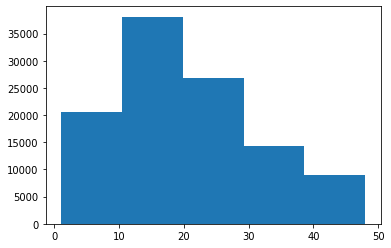

Example Vietnamese input: ['Adam', 'Sadowsky', 'dàn', 'dựng', '1', 'video', 'âm', 'nhạc', 'hiện', 'tượng', '.']
Its target English output: ['Adam', 'Sadowsky', ':', 'How', 'to', 'engineer', 'a', 'viral', 'music', 'video']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def read_sentence_file(filename):
  sentences_list = []
  with open(filename, "r") as f:
    for line in f:
      sentences_list.append(line.strip().split())
  return sentences_list

def read_vocab_file(filename):
  with open(filename, "r") as f:
    return [line.strip() for line in f]


src_vocab_set = read_vocab_file(os.path.join("/content/6864-hw2b", "vocab.vi"))
trg_vocab_set = read_vocab_file(os.path.join("/content/6864-hw2b", "vocab.en"))

train_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                           "train.vi"))
train_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                           "train.en"))
assert len(train_src_sentences_list) == len(train_trg_sentences_list)

test_src_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                          "tst2013.vi"))
test_trg_sentences_list = read_sentence_file(os.path.join("/content/6864-hw2b",
                                                          "tst2013.en"))
assert len(test_src_sentences_list) == len(test_trg_sentences_list)


MAX_SENT_LENGTH = 48
MAX_SENT_LENGTH_PLUS_SOS_EOS = 50

# We only keep sentences that do not exceed 48 words, so that later when we
# add <s> and </s> to a sentence it still won't exceed 50 words.
def filter_data(src_sentences_list, trg_sentences_list, max_len):
  new_src_sentences_list, new_trg_sentences_list = [], []
  for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
    if (len(src_sent) <= max_len and len(trg_sent) <= max_len
        and len(src_sent) > 0 and len(trg_sent)) > 0:
      new_src_sentences_list.append(src_sent)
      new_trg_sentences_list.append(trg_sent)
  return new_src_sentences_list, new_trg_sentences_list

train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, train_trg_sentences_list, max_len=MAX_SENT_LENGTH)
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, test_trg_sentences_list, max_len=MAX_SENT_LENGTH)

# We take 10% of training data as validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# Show some data stats
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))
print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))
print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))
src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')
plt.hist(length, bins=5)
plt.show()

print('Example Vietnamese input: ' + str(train_src_sentences_list[0]))
print('Its target English output: ' + str(train_trg_sentences_list[0]))

Here we define a class called `MTDataset`. It is built on top of the efficient data loader API provided in PyTorch. See Section 5 for explanation.

In [ ]:
import torch
from torch.utils import data

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# These IDs are reserved.
PAD_INDEX = 0
UNK_INDEX = 1
SOS_INDEX = 2
EOS_INDEX = 3


class MTDataset(data.Dataset):
  def __init__(self, src_sentences, src_vocabs, trg_sentences, trg_vocabs,
               sampling=1.):
    self.src_sentences = src_sentences[:int(len(src_sentences) * sampling)]
    self.trg_sentences = trg_sentences[:int(len(src_sentences) * sampling)]

    self.max_src_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS
    self.max_trg_seq_length = MAX_SENT_LENGTH_PLUS_SOS_EOS

    self.src_vocabs = src_vocabs
    self.trg_vocabs = trg_vocabs

    self.src_v2id = {v : i for i, v in enumerate(src_vocabs)}
    self.src_id2v = {val : key for key, val in self.src_v2id.items()}
    self.trg_v2id = {v : i for i, v in enumerate(trg_vocabs)}
    self.trg_id2v = {val : key for key, val in self.trg_v2id.items()}

  def __len__(self):
    return len(self.src_sentences)

  def __getitem__(self, index):
    src_sent = self.src_sentences[index]
    src_len = len(src_sent) + 2   # add <s> and </s> to each sentence
    src_id = []
    for w in src_sent:
      if w not in self.src_vocabs:
        w = '<unk>'
      src_id.append(self.src_v2id[w])
    src_id = ([SOS_INDEX] + src_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_src_seq_length - src_len))

    trg_sent = self.trg_sentences[index]
    trg_len = len(trg_sent) + 2
    trg_id = []
    for w in trg_sent:
      if w not in self.trg_vocabs:
        w = '<unk>'
      trg_id.append(self.trg_v2id[w])
    trg_id = ([SOS_INDEX] + trg_id + [EOS_INDEX] + [PAD_INDEX] *
              (self.max_trg_seq_length - trg_len))

    return torch.tensor(src_id), src_len, torch.tensor(trg_id), trg_len

## **Section 2: Encoder**

Seq2seq consists of an Encoder RNN and a decoder RNN. In a vanilla seq2seq model where there is no attention mechanism between encoder and decoder, the encoder aims to compress the information contained in the entire input sequence into a single vector and pass it to decoder.

We start with implementing the encoder, which is just a simple RNN. We use a GRU here, but feel free to try other cell types.

<img src="https://pytorch.org/tutorials/_images/encoder-network.png" width='200'>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.):
    """
    Inputs: 
      - `input_size`: an int representing the RNN input size.
      - `hidden_size`: an int representing the RNN hidden size.
      - `dropout`: a float representing the dropout rate during training. Note
          that for 1-layer RNN this has no effect since dropout only applies to
          outputs of intermediate layers.
    """
    super(Encoder, self).__init__()
    
    # Note: for lab writeup question #4, you can directly change `num_layers`
    # and `bidirectional` here to enable deep/bidirectional RNNs. However, you
    # will also need to modify some parts in the rest of the code accordingly.
    self.rnn = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True,
                      dropout=dropout, bidirectional=True)

  def forward(self, inputs, lengths):
    """
    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of source
          sentences.
      - `lengths`: a 1d-tensor of shape (batch_size,) representing the sequence
          lengths of `inputs`.

    Returns:
      - `outputs`: a 3d-tensor of shape
        (batch_size, max_seq_length, hidden_size).
      - `finals`: a 3d-tensor of shape (num_layers, batch_size, hidden_size).
      Hint: `outputs` and `finals` are both standard GRU outputs. Check:
      https://pytorch.org/docs/stable/nn.html#gru
    """
    packed_inputs = pack_padded_sequence(inputs,lengths,batch_first=True,enforce_sorted=False) #inputs([128, 50, 256]), lengths 128
    outputs, finals = self.rnn(packed_inputs) #output(128,50,256), finals(1,128,256) / 
                                              #Bi-directions: outputs ([128, 50, 512]), final torch.Size([2, 128, 256])
    outputs, _ = pad_packed_sequence(outputs, batch_first=True, total_length=MAX_SENT_LENGTH_PLUS_SOS_EOS)

    return outputs, finals

## **Section 3: Decoder**

Here you will implement a decoder RNN that uses encoder's last hidden state to initialize its initial hidden state.

<img src='https://pytorch.org/tutorials/_images/decoder-network.png' width='200'>

In [ ]:
class Decoder(nn.Module):
  """An RNN decoder without attention."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(Decoder, self).__init__()
    self.dropout=nn.Dropout(p=dropout)
    self.pre_output=nn.Linear((hidden_size*2)+input_size,hidden_size,bias=False) #(512,256)
    self.f_hidden = nn.Linear(hidden_size, hidden_size)
    self.rnn = nn.GRU(input_size, hidden_size, num_layers=2, batch_first=True,
                      dropout=dropout, bidirectional=True)
    
  def forward(self, inputs, encoder_finals, hidden=None, max_len=None):
    """Unroll the decoder one step at a time.

    Inputs:
      - `inputs`: a 3d-tensor of shape (batch_size, max_seq_length, embed_size)
          representing a batch of padded embedded word vectors of target
          sentences (for teacher-forcing during training).
      - `encoder_finals`: a 3d-tensor of shape
          (num_enc_layers, batch_size, hidden_size) representing the final
          encoder hidden states used to initialize the initial decoder hidden
          states.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size) representing
          the value to be used to initialize the initial decoder hidden states.
          If None, then use `encoder_finals`.
      - `max_len`: an int representing the maximum decoding length.

    Returns:
      - `outputs`: a 3d-tensor of shape
          (batch_size, max_seq_length, hidden_size) representing the raw
          decoder outputs (before converting to a `trg_vocab_size`-dim vector).
          We will convert it later in a `Generator` below.
      - `hidden`: a 3d-tensor of shape (1, batch_size, hidden_size)
          representing the last decoder hidden state.
    """
    
    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = inputs.size(1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)#encoder_finals)

    pre_outputs = []
    for i in range(max_len):
      prev_embed=inputs[:,i].unsqueeze(1)
      #context=hidden[-1].unsqueeze(0)
      
      #Bi-directional: prev_embed [128, 1, 256], hidden [2, 128, 256]
      output, hidden = self.rnn(prev_embed,hidden) #output [128, 1, 512]
      pre_output=torch.cat([prev_embed, output], dim=2)
      pre_output=self.dropout(pre_output)
      pre_output=self.pre_output(pre_output) #Bi-dir: pre_output torch.Size([128, 1, 768])
      pre_outputs.append(pre_output)

    outputs=torch.cat(pre_outputs, dim=1)
    
    return hidden, outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    ### Your code here!
    return torch.tanh(self.f_hidden(encoder_finals))

Define the high level encoder-decoder class to wrap up sub-models, including encoder, decoder, generator, and src/trg embeddings.

In [ ]:
class EncoderDecoder(nn.Module):
  """A standard Encoder-Decoder architecture without attention.
  """
  def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `Decoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths) #src_ids 128x50
    del encoder_hiddens   # unused
    
    return self.decode(encoder_finals, trg_ids[:, :-1])

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)
    
  def decode(self, encoder_finals, trg_ids, decoder_hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_finals, decoder_hidden)

It simply projects the pre-output layer (x in the forward function below) to obtain the output layer, so that the final dimension is the target vocabulary size.

In [ ]:
class Generator(nn.Module):
  """Define standard linear + softmax generation step."""
  def __init__(self, hidden_size, vocab_size):
    super(Generator, self).__init__()
    self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

## **Section 4: Attention-Based Decoder**

Now it's time to add some attention to the decoder. You can implement any attention mechanism you want.

<img src="https://pytorch.org/tutorials/_images/attention-decoder-network.png" width='300'>


In [ ]:
class AttentionDecoder(nn.Module):
  """Bahdanau Attention. An attention-based RNN decoder."""

  def __init__(self, input_size, hidden_size, dropout=0.):
    """
      Inputs:
        - `input_size`, `hidden_size`, and `dropout` the same as in Encoder.
    """
    super(AttentionDecoder, self).__init__()
    
    self.rnn = nn.GRU(input_size + (hidden_size*2), hidden_size, num_layers=2, batch_first=True,
                      dropout=dropout, bidirectional=True)
    ##attention
    self.alphas=None
    self.query=nn.Linear(hidden_size, hidden_size, bias=False)
    self.energy=nn.Linear(hidden_size, 1, bias=False)
    self.key=nn.Linear(hidden_size+hidden_size,hidden_size, bias=False)

    self.dropout=nn.Dropout(p=dropout)
    self.pre_output=nn.Linear(((hidden_size+hidden_size)*2)+input_size,hidden_size,bias=False)
    self.f_hidden = nn.Linear(hidden_size, hidden_size)
    

  def forward(self, inputs, encoder_hiddens, encoder_finals,
              src_mask, trg_mask, hidden=None, max_len=None):
    # The maximum number of steps to unroll the RNN.
    if max_len is None:
      max_len = trg_mask.size(-1)

    # Initialize decoder hidden state.
    if hidden is None:
      hidden = self.init_hidden(encoder_finals)
    proj_key=self.key(encoder_hiddens) #encoder_hiddens torch.Size([128, 50, 512])
    pre_outputs = []
    decoder_states = []

    #for loop step forward
    for i in range(max_len):
      prev_embed=inputs[:,i].unsqueeze(1)
      #Attention function
      query=hidden[-1].unsqueeze(1)
      context, attn_probs = self.attention(query, proj_key, encoder_hiddens, src_mask)
      
      rnn_input=torch.cat([prev_embed,context],dim=2)
      #prev_embed ([128, 1, 256]), context ([128, 1, 512])

      output, hidden = self.rnn(rnn_input,hidden)
      #rnn_input ([128, 1, 768]), hidden ([2, 128, 256])
      
      pre_output=torch.cat([prev_embed, output, context], dim=2) #pre_output torch.Size([128, 1, 1280])
      pre_output=self.dropout(pre_output)
      pre_output=self.pre_output(pre_output)
      pre_outputs.append(pre_output)

    pre_outputs=torch.cat(pre_outputs, dim=1)
    return hidden, pre_outputs

  def init_hidden(self, encoder_finals):
    """Use encoder final hidden state to initialize decoder's first hidden
    state."""
    return torch.tanh(self.f_hidden(encoder_finals))

  def attention(self, query, proj_key, encoder_hiddens, mask):
    query=self.query(query)

    scores=self.energy(torch.tanh(query+proj_key))
    scores=scores.squeeze(2).unsqueeze(1)
    scores.data.masked_fill_(mask == 0, -float('inf'))
    
    alphas=F.softmax(scores,dim=-1)
    self.alphas=alphas
    
    context=torch.bmm(alphas, encoder_hiddens)

    return context, alphas

Similarly, we use a `EncoderAttentionDecoder` class to wrap up all encoder, decoder, src/trg embeddings, and generator. You can take the `EncoderDecoder` class as a reference.

In [ ]:
class EncoderAttentionDecoder(nn.Module):
  """A Encoder-Decoder architecture with attention.
  """
  def __init__(self, encoder, decoder, src_embed , trg_embed, generator):
    """
    Inputs:
      - `encoder`: an `Encoder` object.
      - `decoder`: an `AttentionDecoder` object.
      - `src_embed`: an nn.Embedding object representing the lookup table for
          input (source) sentences.
      - `trg_embed`: an nn.Embedding object representing the lookup table for
          output (target) sentences.
      - `generator`: a `Generator` object. Essentially a linear mapping. See
          the next code cell.
    """
    super(EncoderAttentionDecoder, self).__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.trg_embed = trg_embed
    self.generator = generator

  def forward(self, src_ids, trg_ids, src_lengths):
    """Take in and process masked source and target sequences.

    Inputs:
      `src_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of source sentences of word ids.
      `trg_ids`: a 2d-tensor of shape (batch_size, max_seq_length) representing
        a batch of target sentences of word ids.
      `src_lengths`: a 1d-tensor of shape (batch_size,) representing the
        sequence length of `src_ids`.

    Returns the decoder outputs, see the above cell.
    """
    ### Your code here!
    # You can refer to `EncoderDecoder` and extend from it.
    encoder_hiddens, encoder_finals = self.encode(src_ids, src_lengths)
    src_mask = (src_ids != PAD_INDEX).unsqueeze(-2)
    trg_mask = (trg_ids[:, 1:] != PAD_INDEX).unsqueeze(-2)
    return self.decode(encoder_hiddens, encoder_finals,
                       src_mask, trg_ids[:, :-1], trg_mask)

  def encode(self, src_ids, src_lengths):
    return self.encoder(self.src_embed(src_ids), src_lengths)

  def decode(self, encoder_hiddens, encoder_finals, src_mask, 
             trg_ids, trg_mask, hidden=None):
    return self.decoder(self.trg_embed(trg_ids), encoder_hiddens,
                        encoder_finals, src_mask, trg_mask, hidden)
    

## **Section 5: Training and Testing**

We provide training and testing scripts here. You might need to adapt them to fit your model implementation.

Apply the dataloader to the MT dataset. Dataloader provides a convenient way to iterate through the whole dataset.

In [ ]:
batch_size = 128

# You can try on a smaller training set by setting a smaller `sampling`.
train_set = MTDataset(train_src_sentences_list, src_vocab_set,
                      train_trg_sentences_list, trg_vocab_set, sampling=0.3)
train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    num_workers=8, shuffle=True)

val_set = MTDataset(val_src_sentences_list, src_vocab_set,
                    val_trg_sentences_list, trg_vocab_set, sampling=1.)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size, num_workers=8,
                                  shuffle=False)


The main functions for training, here we use perplexity to evaluate the performance of the model. Although we provide the training scripts here, we strongly encoureage you to go through and understand the procedure.

In [ ]:
import math


class SimpleLossCompute:
  """A simple loss compute and train function."""

  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1))
    loss = loss / norm

    if self.opt is not None:  # training mode
      loss.backward()          
      self.opt.step()
      self.opt.zero_grad()

    return loss.data.item() * norm


def run_epoch(data_loader, model, loss_compute, print_every):
  """Standard Training and Logging Function"""

  total_tokens = 0
  total_loss = 0

  for i, (src_ids_BxT, src_lengths_B, trg_ids_BxL, trg_lengths_B) in enumerate(data_loader):
    # We define some notations here to help you understand the loaded tensor
    # shapes:
    #   `B`: batch size
    #   `T`: max sequence length of source sentences
    #   `L`: max sequence length of target sentences; due to our preprocessing
    #        in the beginning, `L` == `T` == 50
    # An example of `src_ids_BxT` (when B = 2):
    #   [[2, 4, 6, 7, ..., 4, 3, 0, 0, 0],
    #    [2, 8, 6, 5, ..., 9, 5, 4, 3, 0]]
    # The corresponding `src_lengths_B` would be [47, 49].
    # Note that SOS_INDEX == 2, EOS_INDEX == 3, and PAD_INDEX = 0.
    
    src_ids_BxT = src_ids_BxT.to(device)
    src_lengths_B = src_lengths_B.to(device)
    trg_ids_BxL = trg_ids_BxL.to(device)
    del trg_lengths_B   # unused

    _, output = model(src_ids_BxT, trg_ids_BxL, src_lengths_B) #(128x50, 128x50, 128)
    loss = loss_compute(x=output, y=trg_ids_BxL[:, 1:],
                        norm=src_ids_BxT.size(0))
    total_loss += loss
    total_tokens += (trg_ids_BxL[:, 1:] != PAD_INDEX).data.sum().item()

    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss: %f" % (i, loss / src_ids_BxT.size(0)))

  return math.exp(total_loss / float(total_tokens))


def train(model, num_epochs, learning_rate, print_every):
  # Set `ignore_index` as PAD_INDEX so that pad tokens won't be included when
  # computing the loss.
  criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Keep track of dev ppl for each epoch.
  dev_ppls = []
  
  for epoch in range(num_epochs):
    print("Epoch", epoch)

    model.train()
    
    train_ppl = run_epoch(data_loader=train_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, optim),
                          print_every=print_every)
    
    model.eval()
    with torch.no_grad():      
      dev_ppl = run_epoch(data_loader=val_data_loader, model=model,
                          loss_compute=SimpleLossCompute(model.generator,
                                                         criterion, None),
                          print_every=print_every)
      print("Validation perplexity: %f" % dev_ppl)
      dev_ppls.append(dev_ppl)
        
  return dev_ppls

The main function to perform training. First let's train the vanilla seq2seq model.

In [ ]:
# Hyperparameters for contructing the encoder-decoder model.

embed_size = 256   # Each word will be represented as a `embed_size`-dim vector.
hidden_size = 256  # RNN hidden size.
dropout = 0.2

pure_seq2seq = EncoderDecoder(
  encoder=Encoder(embed_size, hidden_size, dropout=dropout),
  decoder=Decoder(embed_size, hidden_size, dropout=dropout),
  src_embed=nn.Embedding(len(src_vocab_set), embed_size),
  trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
  generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

# Start training. The returned `dev_ppls` is a list of dev perplexity for each
# epoch.
pure_dev_ppls = train(pure_seq2seq, num_epochs=10, learning_rate=1e-3,
                      print_every=100)

Epoch 0
Epoch Step: 0 Loss: 182.880798
Epoch Step: 100 Loss: 91.669334
Epoch Step: 200 Loss: 93.259537
Validation perplexity: 98.540984
Epoch 1
Epoch Step: 0 Loss: 86.003235
Epoch Step: 100 Loss: 73.164772
Epoch Step: 200 Loss: 77.642097
Validation perplexity: 73.621381
Epoch 2
Epoch Step: 0 Loss: 65.135788
Epoch Step: 100 Loss: 63.168003
Epoch Step: 200 Loss: 70.348282
Validation perplexity: 64.611251
Epoch 3
Epoch Step: 0 Loss: 56.156826
Epoch Step: 100 Loss: 59.947754
Epoch Step: 200 Loss: 59.382797
Validation perplexity: 60.999240
Epoch 4
Epoch Step: 0 Loss: 55.449478
Epoch Step: 100 Loss: 58.788445
Epoch Step: 200 Loss: 56.791939
Validation perplexity: 61.471873
Epoch 5
Epoch Step: 0 Loss: 48.051815
Epoch Step: 100 Loss: 54.549690
Epoch Step: 200 Loss: 49.064556
Validation perplexity: 64.299895
Epoch 6
Epoch Step: 0 Loss: 47.952785
Epoch Step: 100 Loss: 49.582363
Epoch Step: 200 Loss: 46.047203
Validation perplexity: 68.308682
Epoch 7
Epoch Step: 0 Loss: 46.903194
Epoch Step: 100 

Plot the perplexity graph.

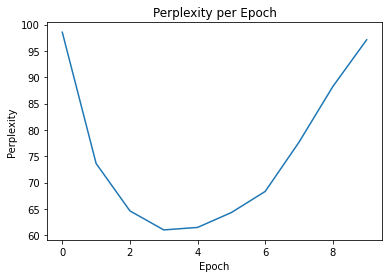

In [ ]:
def plot_perplexity(perplexities):
  """plot perplexities"""
  plt.title("Perplexity per Epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Perplexity")
  plt.plot(perplexities)

plot_perplexity(pure_dev_ppls)

Now, let's train the seq2seq model with attention.

Epoch 0
Epoch Step: 0 Loss: 170.621323
Epoch Step: 100 Loss: 85.499222
Epoch Step: 200 Loss: 76.459938
Validation perplexity: 63.791060
Epoch 1
Epoch Step: 0 Loss: 76.087257
Epoch Step: 100 Loss: 67.610184
Epoch Step: 200 Loss: 63.041695
Validation perplexity: 40.330100
Epoch 2
Epoch Step: 0 Loss: 53.156822
Epoch Step: 100 Loss: 54.204525
Epoch Step: 200 Loss: 53.270298
Validation perplexity: 32.092949
Epoch 3
Epoch Step: 0 Loss: 43.515587
Epoch Step: 100 Loss: 49.488617
Epoch Step: 200 Loss: 42.096428
Validation perplexity: 30.358938
Epoch 4
Epoch Step: 0 Loss: 39.510685
Epoch Step: 100 Loss: 37.753311
Epoch Step: 200 Loss: 42.572861
Validation perplexity: 29.608491
Epoch 5
Epoch Step: 0 Loss: 34.173660
Epoch Step: 100 Loss: 34.745983
Epoch Step: 200 Loss: 36.733875
Validation perplexity: 31.004533
Epoch 6
Epoch Step: 0 Loss: 27.631475
Epoch Step: 100 Loss: 31.264221
Epoch Step: 200 Loss: 35.284344
Validation perplexity: 32.594251
Epoch 7
Epoch Step: 0 Loss: 27.839149
Epoch Step: 100 

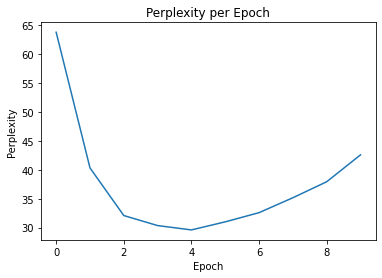

In [ ]:
attn_seq2seq = EncoderAttentionDecoder(
    encoder=Encoder(embed_size, hidden_size, dropout=dropout),
    decoder=AttentionDecoder(embed_size, hidden_size, dropout=dropout),
    src_embed=nn.Embedding(len(src_vocab_set), embed_size),
    trg_embed=nn.Embedding(len(trg_vocab_set), embed_size),
    generator=Generator(hidden_size, len(trg_vocab_set))).to(device)

attn_dev_ppls = train(attn_seq2seq, num_epochs=10, learning_rate=1e-3,
                      print_every=100)

plot_perplexity(attn_dev_ppls)

This is the function used to decode the model output. For simplicity, we use greedy search here.

In [ ]:
def greedy_decode(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderDecoder."""

  with torch.no_grad():
    _, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)

  output = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_finals, prev_y, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).type_as(src_ids).fill_(next_word)

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]
  return output


def greedy_decode_attention(model, src_ids, src_lengths, max_len):
  """Greedily decode a sentence for EncoderAttentionDecoder."""

  with torch.no_grad():
    src_mask = (src_ids != PAD_INDEX).unsqueeze(-2)
    encoder_hiddens, encoder_finals = model.encode(src_ids, src_lengths)
    prev_y = torch.ones(1, 1).fill_(SOS_INDEX).type_as(src_ids)
    trg_mask = torch.ones_like(prev_y)

  output = []
  attention_scores = []
  hidden = None

  for i in range(max_len):
    with torch.no_grad():
      hidden, outputs = model.decode(encoder_hiddens, encoder_finals, src_mask,
                                     prev_y, trg_mask, hidden)
      prob = model.generator(outputs[:, -1])

    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data.item()
    output.append(next_word)
    prev_y = torch.ones(1, 1).fill_(next_word).type_as(src_ids)
    attention_scores.append(model.decoder.alphas.cpu().numpy())

  output = np.array(output)

  # Cut off everything starting from </s>.
  first_eos = np.where(output == EOS_INDEX)[0]
  if len(first_eos) > 0:
    output = output[:first_eos[0]]

  return output, np.concatenate(attention_scores, axis=1)
  
def lookup_words(x, vocab):
  return [vocab[i] for i in x]

Print the top 3 examples from the data loader by applying the greedy decoder.

In [ ]:
def print_examples(model, data_loader, n=3,
                   max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS, 
                   src_vocab_set=src_vocab_set, trg_vocab_set=trg_vocab_set):
  """Prints `n` examples. Assumes batch size of 1."""

  model.eval()

  for i, (src_ids, src_lengths, trg_ids, _) in enumerate(data_loader):
    if isinstance(model, EncoderDecoder):
      result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                             max_len=max_len)
    elif isinstance(model, EncoderAttentionDecoder):
      result, _ = greedy_decode_attention(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=max_len)
    else:
      raise NotImplementedError("Unknown model type.")

    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    print("Example #%d" % (i + 1))
    print("Src : ", " ".join(lookup_words(src_ids, vocab=src_vocab_set)))
    print("Trg : ", " ".join(lookup_words(trg_ids, vocab=trg_vocab_set)))
    print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab_set)))
    print()

    if i == n - 1:
      break

Here we use the validation dataset to print examples.

In [ ]:
example_set = MTDataset(val_src_sentences_list, src_vocab_set,
                        val_trg_sentences_list, trg_vocab_set)
example_data_loader = data.DataLoader(val_set, batch_size=1, num_workers=1,
                                      shuffle=False)

print_examples(pure_seq2seq, example_data_loader)

print_examples(attn_seq2seq, example_data_loader)

Example #1
Src :  Khoa học đằng sau một tiêu đề về khí hậu
Trg :  Rachel <unk> : The science behind a climate headline
Pred:  The next question is , there &apos;s a crisis of global warming .

Example #2
Src :  Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo .
Trg :  I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Pred:  I want to show you the new <unk> of the potential of the brain .

Example #3
Src :  Có những dòng trông như thế này khi bàn về biến đổi khí hậu , và như thế này khi nói về chất lượng không khí hay khói bụi .
Trg :  <unk> that look like this when they have to do with climate change , and headlines that look like this when they have to do with air quality or smog .
Pred:  There are all sorts of things that look like when this current events of carbon , in this case , is the plot that &apos;s heading into the gr

Compute the BLEU score. BLEU score is a standard measure to evaluate the translation results. For further details, you can refer to [this](https://en.wikipedia.org/wiki/BLEU) link.

In [ ]:
import sacrebleu
from tqdm import tqdm


def compute_BLEU(model, data_loader):
  bleu_score = []

  model.eval()
  for src_ids, src_lengths, trg_ids, _ in tqdm(data_loader):
    if isinstance(model, EncoderDecoder):
      result = greedy_decode(model, src_ids.to(device), src_lengths.to(device),
                             max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    elif isinstance(model, EncoderAttentionDecoder):
      result, _ = greedy_decode_attention(model, src_ids.to(device),
                                          src_lengths.to(device),
                                          max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)
    # remove <s>
    src_ids = src_ids[0, 1:]
    trg_ids = trg_ids[0, 1:]
    # remove </s> and <pad>
    src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
    trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]

    pred = " ".join(lookup_words(result, vocab=trg_vocab_set))
    targ = " ".join(lookup_words(trg_ids, vocab=trg_vocab_set))

    bleu_score.append(sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score)

  return bleu_score


test_set = MTDataset(test_src_sentences_list, src_vocab_set,
                     test_trg_sentences_list, trg_vocab_set, sampling=1.)
test_data_loader = data.DataLoader(test_set, batch_size=1, num_workers=8,
                                   shuffle=False)

print('BLEU score: %f' % (np.mean(compute_BLEU(pure_seq2seq,
                                               test_data_loader))))
print('BLEU score: %f' % (np.mean(compute_BLEU(attn_seq2seq,
                                               test_data_loader))))

  0%|          | 0/1139 [00:00<?, ?it/s]

BLEU score: 4.586987


100%|██████████| 1139/1139 [02:22<00:00,  7.98it/s]

BLEU score: 12.320721


### **Visualizing Attention**

In [ ]:
import matplotlib.font_manager as font_manager

def plot_heatmap(src, trg, scores):
  fig, ax = plt.subplots(figsize=(10, 8))
  heatmap = ax.pcolor(scores, cmap='viridis')
  plt.xlabel('English', fontsize=16)
  plt.ylabel('Vietnamese', fontsize=16)

  ax.xaxis.set_label_position('top')   
  ax.set_xticklabels(trg, minor=False, rotation='vertical')
  ax.set_yticklabels(src, minor=False)
  
  ax.xaxis.tick_top()
  ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
  ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
  ax.invert_yaxis()
  
  plt.colorbar(heatmap)
  plt.show()








  0%|          | 0/812 [00:00<?, ?it/s]


src ['Tôi', 'đã', 'rất', 'tự', 'hào', 'về', 'đất', 'nước', 'tôi', '.', '</s>']
pred ['I', 'was', 'legally', 'about', 'the', 'country', ',', 'and', 'I', 'get', 'the', 'Earth', '.', '</s>']
attention (11, 14)


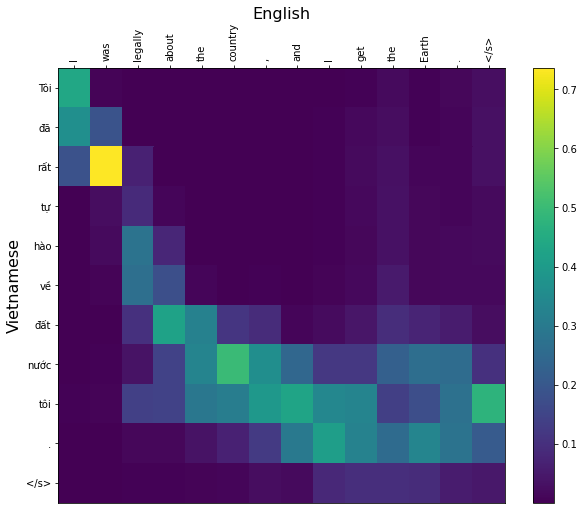

In [ ]:
alphas = []
model=attn_seq2seq
model.eval()

for src_ids, src_lengths, trg_ids, _ in tqdm(test_data_loader):
  output, attention = greedy_decode_attention(model, src_ids.to(device), src_lengths.to(device),
                                              max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS)

  # remove <s>
  src_ids = src_ids[0, 1:]
  trg_ids = trg_ids[0, 1:]
  # remove </s> and <pad>
  src_ids = src_ids[:np.where(src_ids == EOS_INDEX)[0][0]]
  trg_ids = trg_ids[:np.where(trg_ids == EOS_INDEX)[0][0]]
  
  src=" ".join(lookup_words(src_ids, vocab=src_vocab_set))
  trg=" ".join(lookup_words(trg_ids, vocab=trg_vocab_set))
  pred=" ".join(lookup_words(output, vocab=trg_vocab_set))
  
  hypotheses=[pred]
  alphas.append(attention)
  break

pred=hypotheses[0].split()+["</s>"]
src= src.split()+["</s>"]
pred_att=alphas[0][0].T[1:len(src)+1, :len(pred)]

print("src",src)
print("pred",pred)
print("attention",pred_att.shape)
plot_heatmap(src,pred,pred_att)

## **Part 3: Lab writeup**

Your lab report should discuss any implementation details that were important to filling out the code above. Then, use the code to set up experiments that answer the following questions:

1. In this lab we use greedy search for decoding, that is, always taking the most probable word at current timestep as prediction. Describe an alternative decoding method that might work better than greedy search. You don't have to implement it.

2. Pick some samples from dev or test set and visualize their attention maps. Discuss your findings. Hint: compute the attention scores on the input words for each timestep during decoding.

3. Compare the performance of seq2seq with and without attention on sentences of different lengths. You can set some length intervals (e.g., 1-10, 11-20, 21-30, 31-40, 41-50) and compare the two models' performance within each length interval. Discuss your findings.

4. Try to improve your BLEU score. For example, try stacking more RNN layers, switching cell types, or applying bi-direction to encoder. Describe what you try, even if they don't show improvement. Hints:
  * TA's preliminary implemtation of seq2seq with attention model achieves around 16. You don't have to surpass it (although it's pretty simple to do so)--this number is just to give you some sense of what a baseline should get.
  * Training on the entire training set takes some time. So tune your hyperparameters on a smaller training set (you can do so by changing `sampling` when creating the data loader).